In [1]:
# implementation of a character-based RNN to generate sonnets
import numpy as np
import random
import string
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Lambda
from keras.layers import SimpleRNN,LSTM
from keras.callbacks import LambdaCallback, EarlyStopping

In [2]:
def preprocess(filename="shakespeare.txt", seq_length=40, step=5):
    '''
    returns semi-redundant sequences their outputs 
    seq_length: number of characters in each sequence
    step: gets every [step] sequence  
    '''

    # puts all data into text string  
    file = open(filename, "r")
    text = ""
    for line in file:
        line = line.lstrip(' ').rstrip(' ')
        if line != '\n' and not line[0].isdigit():
            line.translate(str.maketrans('', '', string.punctuation))
            text += line.lower()

    # make char to index and index to char dictionary 
    characters = sorted(list(set(text)))
    char_indices_dict = dict((c, i) for i, c in enumerate(characters))
    indices_char_dict = dict((i, c) for i, c in enumerate(characters))
    #print(char_indices_dict)

    # makes every [step] char sequences of length seq_length and their outputs
    sequences = []
    next_chars = [] # next char that seq in sequences generates
    #print(repr(text[len(text) - 200:]))
    for i in range(0, len(text) - seq_length, step):
        #print(i, seq, text[i : i + seq_length])
        sequences.append(text[i : i + seq_length])
        next_chars.append(text[i + seq_length])

    # put sequences and outputs into np array
    x = np.zeros((len(sequences), seq_length, len(characters)))
    y = np.zeros((len(sequences), len(characters)), dtype=np.bool)
    for i, sequence in enumerate(sequences):
        for t, char in enumerate(sequence):
            x[i, t, char_indices_dict[char]] = 1
        y[i, char_indices_dict[next_chars[i]]] = 1

    return x, y, sequences, indices_char_dict, char_indices_dict, text

In [3]:
#seq_length: number of characters in each sequence
#step: gets every [step] sequence  

seq_length=40
step=5    
filename="shakespeare.txt"
# puts all data into text string  
file = open(filename, "r")
text = ""
for line in file:
    line = line.lstrip(' ').rstrip(' ')
    if line != '\n' and not line[0].isdigit():
        line.translate(str.maketrans('', '', string.punctuation))
        text += line.lower()

In [4]:
# make char to index and index to char dictionary 
characters = sorted(list(set(text)))
char_indices_dict = dict((c, i) for i, c in enumerate(characters))
indices_char_dict = dict((i, c) for i, c in enumerate(characters))
print(char_indices_dict)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [6]:
# makes every [step] char sequences of length seq_length and their outputs
sequences = []
next_chars = [] # next char that seq in sequences generates
print(repr(text[len(text) - 200:]))

"fire took heat perpetual,\ngrowing a bath and healthful remedy,\nfor men discased, but i my mistress' thrall,\ncame there for cure and this by that i prove,\nlove's fire heats water, water cools not love."


In [7]:
# using rnn to build model
def make_rnn(temperature=1.0):
    model = Sequential()
    model.add(SimpleRNN(100))
    # add temperature (controls variance)
    model.add(Lambda(lambda x: x / temperature))
    model.add(Dense(len(indices_char_dict), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

def make_lstm(temperature=1.0):
    model = Sequential()
    model.add(LSTM(100))
    # add temperature (controls variance)
    model.add(Lambda(lambda x: x / temperature))
    model.add(Dense(len(indices_char_dict), activation='softmax'))  
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [8]:
# model summary for RNN
x, y, sequences, indices_char_dict, char_indices_dict, text = preprocess()
print('model summary for rnn \n')
rnn_model=make_rnn(0.2)
rnn_model.build(x.shape)
rnn_model.summary()

model summary for rnn 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (18727, 100)              13900     
_________________________________________________________________
lambda (Lambda)              (18727, 100)              0         
_________________________________________________________________
dense (Dense)                (18727, 38)               3838      
Total params: 17,738
Trainable params: 17,738
Non-trainable params: 0
_________________________________________________________________


In [9]:
# model summary for lstm
print('model summary for lstm \n')
lstm_model=make_lstm(0.2)
lstm_model.build(x.shape)
lstm_model.summary()

model summary for lstm 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (18727, 100)              55600     
_________________________________________________________________
lambda_1 (Lambda)            (18727, 100)              0         
_________________________________________________________________
dense_1 (Dense)              (18727, 38)               3838      
Total params: 59,438
Trainable params: 59,438
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training for RNN
earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
rnn_history=rnn_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
rnn_model.save('rnn.h5')

Epoch 1/50
586/586 [==============================] - 42s 28ms/step - loss: 3.0551 - accuracy: 0.2013
Epoch 2/50
586/586 [==============================] - 17s 29ms/step - loss: 2.3132 - accuracy: 0.3305
Epoch 3/50
586/586 [==============================] - 17s 29ms/step - loss: 2.1801 - accuracy: 0.3607
Epoch 4/50
586/586 [==============================] - 17s 29ms/step - loss: 2.1309 - accuracy: 0.3655
Epoch 5/50
586/586 [==============================] - 17s 29ms/step - loss: 2.1192 - accuracy: 0.3660
Epoch 6/50
586/586 [==============================] - 17s 29ms/step - loss: 2.0913 - accuracy: 0.3744
Epoch 7/50
586/586 [==============================] - 16s 27ms/step - loss: 2.0946 - accuracy: 0.3742
Epoch 8/50
586/586 [==============================] - 16s 27ms/step - loss: 2.0667 - accuracy: 0.3792
Epoch 9/50
586/586 [==============================] - 16s 27ms/step - loss: 2.0599 - accuracy: 0.3817
Epoch 10/50
586/586 [==============================] - 16s 28ms/step - loss: 2.033

In [11]:
#  training for LSTM
earlyStopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')
lstm_history=lstm_model.fit(x, y, epochs=50, verbose=1, callbacks=[earlyStopping])
lstm_model.save('lstm.h5')

Epoch 1/50
586/586 [==============================] - 7s 5ms/step - loss: 2.8836 - accuracy: 0.1982
Epoch 2/50
586/586 [==============================] - 3s 5ms/step - loss: 2.3096 - accuracy: 0.3259
Epoch 3/50
586/586 [==============================] - 3s 5ms/step - loss: 2.1777 - accuracy: 0.3557
Epoch 4/50
586/586 [==============================] - 3s 4ms/step - loss: 2.0745 - accuracy: 0.3876
Epoch 5/50
586/586 [==============================] - 3s 5ms/step - loss: 2.0165 - accuracy: 0.4003
Epoch 6/50
586/586 [==============================] - 3s 5ms/step - loss: 1.9354 - accuracy: 0.4213
Epoch 7/50
586/586 [==============================] - 3s 5ms/step - loss: 1.8869 - accuracy: 0.4359
Epoch 8/50
586/586 [==============================] - 3s 5ms/step - loss: 1.8239 - accuracy: 0.4518
Epoch 9/50
586/586 [==============================] - 3s 5ms/step - loss: 1.7853 - accuracy: 0.4567
Epoch 10/50
586/586 [==============================] - 3s 5ms/step - loss: 1.7362 - accuracy: 0.4734

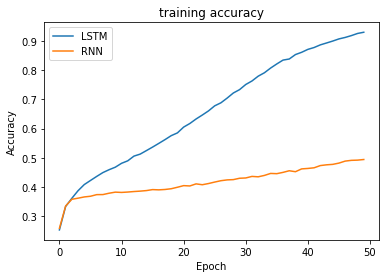

In [12]:
import matplotlib.pyplot as plt
# plot accuracy
plt.plot(lstm_history.history['accuracy'])
plt.plot(rnn_history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'RNN'], loc='upper left')
plt.show()

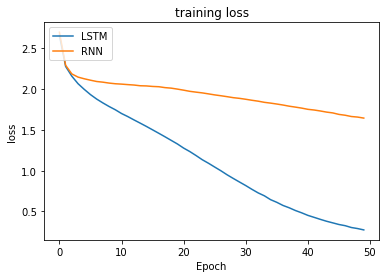

In [13]:
# plot loss
plt.plot(lstm_history.history['loss'])
plt.plot(rnn_history.history['loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'RNN'], loc='upper left')
plt.show()

In [14]:
def generate_sonnet(model_choice='rnn'):

    if model_choice=='rnn':
        model = load_model('rnn.h5')
    elif model_choice=='lstm':
        model = load_model('lstm.h5')
    sonnet = []
    
    seq = "shall i compare thee to a summer's day?\n"
    sonnet.append(seq)
    for _ in range(13):
        line = ""
        for i in range(40):
            x = np.zeros((1, len(seq), len(indices_char_dict)))
            for t, index in enumerate(seq):
                x[0, t, char_indices_dict[index]] = 1.

            prediction = model.predict(x, verbose=0)[0]
            index = np.argmax(prediction)
            char = indices_char_dict[index]
            line += char
            seq = seq[1:] + char

        sonnet.append(line)
    return sonnet

In [15]:
sonnet=generate_sonnet('rnn')
print('sonnet by rnn: \n')
for line in sonnet:
    print(line)

sonnet by rnn: 

shall i compare thee to a summer's day?

on whan the all the with my dothe,
thy l
ove in the word me parse but des all wit
h stie,
thou dast hor swall bornd stees 
for thate,
and the wor dis the ronge sta
re incend of doth pays,
and the werd i h
ore chee frain the wornd.
and all an of 
tought thour as the with doth mate,
for 
then wher in my paine, not rurs comed.
i
n hat you the with my deade,
thou has th
e world that hane wirs the steen,
and th
e wor his chist not sem the with thee,
w
here be the recelind not hath meterefred
 in the cret.
on mis reast the rongre th


In [16]:
sonnet=generate_sonnet('lstm')

print('sonnet by lstm: \n')
for line in sonnet:
    print(line)

sonnet by lstm: 

shall i compare thee to a summer's day?

whils then pare, and meres oweer dight,

and loves of thou stawllef for dith, bea
ghts,
the elour ebest the mery's wornion
 swoeling are,
the elence a daw all nor 
steed
foryien of the braut,
that heawty 
may thin a oth thy meare,
o now and thei
r uraury are bleakion swelles of thy hag
agast,
dot mines me thy most thoughe on 
the ofonone,
rise to the cerone chalt of
 up forctalovencce.

and ever therefill 
but stllwere, the thin oth lovestrout ti
me as
mowe that eye heaw artauines butid
e,
whall though shell selive thy swel tr
